In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import h5py
from HelperAndMechanics import *
from matplotlib import cm
from ipywidgets import *
import seaborn as sns
import pandas as pd
import math
import os
import numpy as np
import h5py
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import MaxNLocator

plt.rcParams['text.usetex'] = True
# Set Palatino as the default font
font = {'family': 'serif', 'serif': ['Palatino'], 'size': 20}
plt.rc('font', **font)
plt.rc('text', usetex=True)

In [ ]:
jnp.broadcast_to(1.,(1,1000,100,100)).shape

(1, 1000, 100, 100)

In [ ]:
def list_groups(file_path_in):
    with h5py.File(file_path_in, 'r') as f:
        return [name for name in f if isinstance(f[name], h5py.Group)]

def load_run(file_path_in, run):
    data = {}
    params_dict = {}
    param_trajectories = {}

    with h5py.File(file_path_in, 'r') as f:
        if run not in f:
            raise ValueError(f"Run '{run}' not found in file.")
        group = f[run]
        dataset_keys = ['u_sol', 'u', 'v_sol', 'v', 'T_sol', 'T', 'x_sol', 'x',
                        'u_BOCF', 'v_BOCF', 'T_BOCF', 'x_BOCF', 'losses']
        for key in dataset_keys:
            if key in group:
                data[key] = np.array(group[key])

        # Load recovered parameters
        if "params_train" in group:
            params_group = group["params_train"]
            params_dict = {key: params_group.attrs[key] for key in params_group.attrs}

        # Load parameter trajectories
        if "params_history" in group:
            hist_group = group["params_history"]
            for key in hist_group:
                param_trajectories[key] = np.array(hist_group[key])

    return data, params_dict, param_trajectories

def load_stat_data(file_path_in, mode='AP_AP'):
    run_list = list_groups(file_path_in)
    print("Available runs:", len(run_list))

    u_sol, u_sim = [], []
    v_sol, v_sim = [], []
    T_sol, T_sim = [], []
    x_sol, x_sim = [], []
    losses = []
    params = {}
    param_trajectories_all = {}

    for run in run_list:
        data, params_train, param_trajectories = load_run(file_path_in, run)

        # Initialize parameter and trajectory structures on first run
        if not params:
            params = {key: [] for key in params_train}
        if not param_trajectories_all and param_trajectories:
            param_trajectories_all = {key: [] for key in param_trajectories}

        # Append trajectory data
        for key, traj in param_trajectories.items():
            param_trajectories_all[key].append(traj)

        # Append final trained parameters
        for key in params_train:
            params[key].append(params_train[key])

        # Select data based on mode
        if mode == 'AP_AP':
            u_sol.append(data.get('u_sol', np.array([])))
            u_sim.append(data.get('u', np.array([])))
            v_sol.append(data.get('v_sol', np.array([])))
            v_sim.append(data.get('v', np.array([])))
            T_sol.append(data.get('T_sol', np.array([])))
            T_sim.append(data.get('T', np.array([])))
            x_sol.append(data.get('x_sol', np.array([])))
            x_sim.append(data.get('x', np.array([])))
        elif mode == 'BOCF':
            u_sol.append(data.get('u_sol', np.array([])))
            u_sim.append(data.get('u_BOCF', np.array([])))
            v_sol.append(data.get('v_sol', np.array([])))
            v_sim.append(data.get('v_BOCF', np.array([])))
            T_sol.append(data.get('T_sol', np.array([])))
            T_sim.append(data.get('T_BOCF', np.array([])))
            x_sol.append(data.get('x_sol', np.array([])))
            x_sim.append(data.get('x_BOCF', np.array([])))

        if 'losses' in data:
            losses.append(data['losses'])

    return (
        np.concatenate(u_sol) if u_sol else np.array([]),
        np.concatenate(u_sim) if u_sim else np.array([]),
        np.concatenate(v_sol) if v_sol else np.array([]),
        np.concatenate(v_sim) if v_sim else np.array([]),
        np.concatenate(T_sol) if T_sol else np.array([]),
        np.concatenate(T_sim) if T_sim else np.array([]),
        np.concatenate(x_sol) if x_sol else np.array([]),
        np.concatenate(x_sim) if x_sim else np.array([]),
        losses,
        {key: np.array(val) for key, val in params.items()},
        {key: np.stack(val) for key, val in param_trajectories_all.items()}
    )

def get_gaussian_dist_from_params(params, run, n_gaussians=3, sigma=1):
    """2D Gaussian function"""
    n_dist = np.load('../data/SpringMassModel/FiberOrientation/fiber_orientation.npy')

    centers = jnp.linspace(-1, 1, n_gaussians)
    sum = 0 

    for x0 in range(3):
        for y0 in range(3):
            sum += gaussian_2d(centers[x0], centers[y0], params['Amp'+str(x0)+str(y0)][run], sigma)

    return sum,n_dist

@jit
def compute_dA_stats(x, A_undeformed):
    """
    Computes the relative area change for a time series of quadrilateral meshes.

    Parameters:
    x : ndarray of shape (T, 2, H, M)
        Time series of x and y coordinate grids.
    A_undeformed : float
        The reference (undeformed) area.

    Returns:
    dA : ndarray of shape (T, H-1, M-1)
        The relative area change over time.
    """

    # Compute edge lengths (vectorized over time T)
    a = jnp.linalg.norm(x[:,:, :, 1:, 1:] - x[:,:, :, 1:, :-1], axis=2)  # Right edge
    b = jnp.linalg.norm(x[:,:, :, 1:, 1:] - x[:,:, :, :-1, 1:], axis=2)  # Top edge
    c = jnp.linalg.norm(x[:,:, :, :-1, 1:] - x[:,:, :, :-1, :-1], axis=2)  # Left edge
    d = jnp.linalg.norm(x[:,:, :, 1:, :-1] - x[:,:, :, :-1, :-1], axis=2)  # Bottom edge

    # Compute diagonal lengths
    diagonal1 = jnp.linalg.norm(x[:,:, :, :-1, 1:] - x[:,:, :, 1:, :-1], axis=2)  # Top-left to bottom-right
    diagonal2 = jnp.linalg.norm(x[:,:, :, 1:, 1:] - x[:,:, :, :-1, :-1], axis=2)  # Top-right to bottom-left

    # Compute helper term
    hlp = (b**2 + d**2 - a**2 - c**2)

    # Compute deformed area using the determinant formula
    A_deformed = jnp.sqrt(4 * diagonal1**2 * diagonal2**2 - hlp**2) / 4

    # Compute relative area change
    dA = A_deformed / A_undeformed - 1

    return dA

def plot_gaussian_dist(params, run, file_path_out, save_data=True):
    n_dist_train,n_dist = get_gaussian_dist_from_params(params, run, n_gaussians=3, sigma=1)
    n_dist_train, n_dist = (1-n_dist_train), (1-n_dist)
    n_err = np.abs(n_dist - n_dist_train)

    fig, axes = plt.subplots(1, 3, figsize=(12, 4))

    im0 = axes[0].imshow(n_dist, cmap='viridis', origin='lower', vmin=np.min(n_dist), vmax=np.max(n_dist))
    axes[0].set_title(r"$\eta$ ground truth")
    plt.colorbar(im0, ax=axes[0])

    im1 = axes[1].imshow(n_dist_train, cmap='viridis', origin='lower', vmin=np.min(n_dist), vmax=np.max(n_dist))
    axes[1].set_title(r"$\eta$ reconstruction")
    plt.colorbar(im1, ax=axes[1])

    im2 = axes[2].imshow(n_err, cmap='viridis', origin='lower')
    axes[2].set_title("Absolute Error")
    plt.colorbar(im2, ax=axes[2])

    # plt.suptitle(r"Gaussian Distribution Comparison", fontsize=14)
    plt.tight_layout(rect=[0, 0, 1, 0.95])

    if save_data:
        plt.savefig(file_path_out + 'gaussian_dist_comparison.png')
        plt.close(fig)
    else:
        plt.show()

def plot_loss_curves(losses, file_path_out, save_data=True):
    fig, ax = plt.subplots(2, 1, figsize=(8, 8))
    epochs = np.linspace(0, len(losses[0]) * 10, len(losses[0]))
    max_run = 40
    if len(losses) > max_run:
        losses = losses[:max_run]

    for run in range(len(losses)):
        ax[0].plot(epochs, np.log(losses[run]))
    ax[0].set_xlabel('Epoch')
    ax[0].set_ylabel('log(Loss)')
    ax[0].xaxis.set_major_locator(MaxNLocator(integer=True))  # Integer ticks

    last_losses = [np.log(losses[run][-1, 0]) for run in range(len(losses))]
    ax[1].plot(last_losses, marker='o')
    ax[1].set_xlabel('Run')
    ax[1].set_ylabel('Final log(Loss)')
    ax[1].xaxis.set_major_locator(MaxNLocator(integer=True))  # Integer ticks

    plt.tight_layout()
    if save_data:
        plt.savefig(file_path_out + 'loss_curves.png')
        plt.close(fig)

def violin_plot(file_path_in, mode, selected_keys, params_true, param_labels, file_path_out, title="Normalized Parameters", save_data=True):
    _, _, _, _, _, _, _, _, losses, params,param_history = load_stat_data(file_path_in, mode)
    normalized_params = {key: params[key] / params_true[key] for key in selected_keys if key in params and key in params_true}
    if 'D' in normalized_params:
        normalized_params['D'] = params['D'] / params['spacing']**2 / (params_true['D'] / params_true['spacing']**2)
    df = pd.DataFrame(normalized_params)
    plt.figure(figsize=(12, 6))
    ax = sns.violinplot(data=df, inner="quartile", palette="coolwarm")
    sns.stripplot(data=df, color='black', jitter=True, alpha=0.5, zorder=3)
    plt.grid(True, linestyle="--", alpha=0.6, zorder=0)
    plt.xticks(rotation=0)
    if title == 'GaussianAmplitudes':
        plt.ylabel('Parameter Value')
    else:
        plt.ylabel('Reconstructed Parameter/Ground Truth')
    # plt.title(title)
    xticks = ax.get_xticks()
    xticklabels = [param_labels[tick.get_text()] for tick in ax.get_xticklabels()]
    ax.set_xticklabels(xticklabels)
    k_indices = [i for i, label in enumerate(xticklabels) if label == param_labels['k_ij']]
    if k_indices:
        y_min = ax.get_ylim()[0]
        for x_start, x_end, text in [(-.1, 2.1, 'spring constants'), (4.9, 6.1, 'init active stress')]:
            ax.plot([x_start, x_end], [y_min + 0.05, y_min + 0.05], color='black', linewidth=1.5)
            ax.plot([x_start, x_start], [y_min + 0.05, y_min], color='black', linewidth=1.5)
            ax.plot([x_end, x_end], [y_min + 0.05, y_min], color='black', linewidth=1.5)
            ax.text((x_start + x_end)/2, y_min + 0.26, text, ha='center', va='top', fontsize=16)
        ax.set_ylim(bottom=y_min - 0.2)
    plt.tight_layout()
    if save_data:
        plt.savefig(f'{file_path_out}violin_plot{title}.png')
        plt.close()

def plot_T_error(file_path_in, run, params, params_true, file_path_out, mode='AP_AP', eta_var=False, save_data=True):
    u_sol, _, _, _, T_sol, T_sim, _, _, _, _, _ = load_stat_data(file_path_in, mode)

    l_a_sol = np.sqrt((params['n_0'][run] - params['l_0'][run]/2)**2 + (params['l_0'][run]/2)**2)
    l_a_sim = np.sqrt((params_true['n_0'] - params_true['l_0']/2)**2 + (params_true['l_0']/2)**2)

    if eta_var: 
        n_dist_train, n_dist = get_gaussian_dist_from_params(params, run, n_gaussians=3, sigma=1)
        l_a_sol = np.sqrt((n_dist_train - params['l_0'][run]/2)**2 + (params['l_0'][run]/2)**2)
        l_a_sim = np.sqrt((n_dist - params_true['l_0']/2)**2 + (params_true['l_0']/2)**2)

    l_a_effective_sol = l_a_sol / (1 + params['c_a'][run] * T_sol)
    l_a_effective_sim = l_a_sim / (1 + params_true['c_a'] * T_sim)
    frame_indices = np.linspace(0, T_sol.shape[1] - 1, 3, dtype=int)
    vmax = np.max([l_a_effective_sim[run], l_a_effective_sol[run]])
    vmin = np.min([l_a_effective_sim[run], l_a_effective_sol[run]])
    fig, axs = plt.subplots(3, 3, figsize=(12, 12))
    sampling_rate = 15*0.08
    print(f"vmin: {vmin}, vmax: {vmax}")
    print(f"l_a_sim: {l_a_sim}, l_a_sol: {l_a_sol}")
    for i, frame in enumerate(frame_indices):
        im0 = axs[i, 0].imshow(l_a_effective_sim[run, frame], cmap='coolwarm_r', vmin=vmin, vmax=vmax)
        im1 = axs[i, 1].imshow(l_a_effective_sol[run, frame], cmap='coolwarm_r', vmin=vmin, vmax=vmax)
        im2 = axs[i, 2].imshow(np.abs(l_a_effective_sol[run, frame] - l_a_effective_sim[run, frame]), cmap='coolwarm', vmin=vmin, vmax=vmax)

        axs[i, 0].set_ylabel(f"t= {frame*sampling_rate}")
        for j in range(3):
            axs[i, j].tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)
            axs[i, j].spines[:].set_visible(False)  # Hides spines instead of full axis

    axs[0, 0].set_title(f"$l_a$-eff ground truth")
    axs[0, 1].set_title(f"$l_a$-eff reconstruction")
    axs[0, 2].set_title("Error")
    cbar_ax = fig.add_axes([0.2, 0.05, 0.6, 0.02])
    fig.colorbar(im0, cax=cbar_ax, orientation='horizontal')
    plt.tight_layout(rect=[0, 0.08, 1, 0.97])
    if save_data:
        plt.savefig(file_path_out + 'T_error_heatmap.png')
        plt.close(fig)

def plot_u_error(file_path_in, run, file_path_out, mode='AP_AP', save_data=True):
    u_sol, u_sim, _, _, _, _, _, _, _, _, _ = load_stat_data(file_path_in, mode)
    frame_indices = np.linspace(0, u_sol.shape[1] - 1, 3, dtype=int)
    fig, axs = plt.subplots(3, 3, figsize=(12, 12))
    sampling_rate = 15*0.08
    for i, frame in enumerate(frame_indices):
        im0 = axs[i, 0].imshow(u_sim[run, frame], cmap='coolwarm', vmin=0, vmax=1)
        im1 = axs[i, 1].imshow(u_sol[run, frame], cmap='coolwarm', vmin=0, vmax=1)
        im2 = axs[i, 2].imshow(np.abs(u_sol[run, frame] - u_sim[run, frame]), cmap='coolwarm', vmin=0, vmax=1)

        axs[i, 0].set_ylabel(f"t= {frame*sampling_rate}")
        for j in range(3):
            axs[i, j].tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)
            axs[i, j].spines[:].set_visible(False)  # Hides spines instead of full axis

    axs[0, 0].set_title("u ground truth")
    axs[0, 1].set_title("u reconstruction")
    axs[0, 2].set_title("Error")
    cbar_ax = fig.add_axes([0.2, 0.05, 0.6, 0.02])
    fig.colorbar(im2, cax=cbar_ax, orientation='horizontal')
    plt.tight_layout(rect=[0, 0.08, 1, 0.97])
    if save_data:
        plt.savefig(file_path_out + 'u_err_heatmap.png')
        plt.close(fig)

def plot_dA_error(file_path_in, run, file_path_out, mode='chaos', save_data=True):
    _, _, _, _, _, _, x_sol, x_sim, _, _, _ = load_stat_data(file_path_in, mode='AP_AP')
    pad = 10
    dA_sol = compute_dA(x_sim[run], 1)[:, pad:-pad, pad:-pad]
    dA_sim = compute_dA(x_sol[run], 1)[:, pad:-pad, pad:-pad]
    frame_indices = np.linspace(0, dA_sol.shape[0] - 1, 3, dtype=int)
    print(f"frame_indices: {frame_indices}")
    vmin = -0.2
    vmax = 0.2
    sampling_rate = 15*0.08
    if mode == 'scroll':
        vmin,vmax= np.min(dA_sol), np.max(dA_sol)

    fig, axs = plt.subplots(3, 3, figsize=(12, 12))
    for i, frame in enumerate(frame_indices):
        im0 = axs[i, 0].imshow(dA_sim[frame], cmap='coolwarm', vmin=vmin, vmax=vmax)
        im1 = axs[i, 1].imshow(dA_sol[frame], cmap='coolwarm', vmin=vmin, vmax=vmax)
        im2 = axs[i, 2].imshow((dA_sol[frame] - dA_sim[frame])*10, cmap='coolwarm', vmin=vmin, vmax=vmax)

        axs[i, 0].set_ylabel(f"t= {frame*sampling_rate}")
        for j in range(3):
            axs[i, j].tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)
            axs[i, j].spines[:].set_visible(False)  # Hides spines instead of full axis

    axs[0, 0].set_title("dA ground truth")
    axs[0, 1].set_title("dA reconstruction")
    axs[0, 2].set_title("Error *10")
    cbar_ax = fig.add_axes([0.2, 0.05, 0.6, 0.02])
    fig.colorbar(im0, cax=cbar_ax, orientation='horizontal')
    # plt.tight_layout(rect=[0, 0.08, 1, 0.97])
    if save_data:
        plt.savefig(file_path_out + 'dA_err_heatmap.png')
        plt.close(fig)

def plot_u_mse_over_time(file_path_in, file_path_out, save_data=True):
    u_sol, u_sim, *_ = load_stat_data(file_path_in, mode='AP_AP')
    mean_err_over_time = np.mean((u_sol - u_sim) ** 2, axis=(2, 3)) / np.mean(u_sol ** 2, axis=(2, 3))
    time = np.linspace(0, mean_err_over_time.shape[1], mean_err_over_time.shape[1])
    plt.figure(figsize=(8, 5))
    max_run = 40
    if mean_err_over_time.shape[0] > max_run:
        mean_err_over_time = mean_err_over_time[:max_run]
    for run in range(mean_err_over_time.shape[0]):
        plt.plot(time, mean_err_over_time[run], alpha=0.7)
    plt.xlabel('Time in a.u.')
    plt.ylabel(r'MSE($u$)/Mean($u_{ground truth}$)')
    # plt.title('MSE of u Variable')
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.yscale('log')
    plt.tight_layout()
    if save_data:
        plt.savefig(file_path_out + 'u_mse_over_time.png')
        plt.close()

def plot_loss_vs_param_error_multi_subplots(losses, params, params_true, selected_key_groups, param_labels, file_path_out, error_metric='rel', save_data=True):
    n_runs = len(losses)
    n_groups = len(selected_key_groups)
    n_cols = min(n_groups, 3)
    n_rows = math.ceil(n_groups / n_cols)

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(6 * n_cols, 6 * n_rows), sharey=True)
    axes = np.array(axes).reshape(-1)

    label_group_names = []
    for idx, param_keys in enumerate(selected_key_groups):
        ax = axes[idx]
        loss_vals = [np.min(np.log(losses[run])) for run in range(n_runs)]

        for key in param_keys:
            param_errors = []
            for run in range(n_runs):
                if key == 'D':
                    params[key][run] = params[key][run] / params['spacing'][run]**2
                est, true = params[key][run], params_true[key]
                err = ((est - true) / true) ** 2 if error_metric == 'rel' else (est - true) ** 2
                param_errors.append(np.sqrt(err))
            ax.scatter(loss_vals, param_errors, label=param_labels[key], alpha=0.8, edgecolor='k')

        group_label = "_".join([key.replace(" ", "") for key in param_keys])
        label_group_names.append(group_label)

        ax.set_xlabel("log(Min Loss)")
        if idx % n_cols == 0:
            ax.set_ylabel("Parameter Error/True Value")
        ax.grid(True, linestyle='--', alpha=0.5)
        ax.legend(loc='upper right')

    for j in range(len(selected_key_groups), len(axes)):
        axes[j].axis("off")

    plt.tight_layout(rect=[0, 0, 1, 0.95])

    group_suffix = "__".join(label_group_names)
    group_suffix = group_suffix[:150]
    filename = f"loss_vs_param_error_{error_metric}_{group_suffix}.png"
    full_path = os.path.join(file_path_out, filename)

    if save_data:
        plt.savefig(full_path)
        plt.close()

def plot_param_vs_param_multi_subplots(params, selected_key_groups, param_labels, file_path_out, params_true, save_data=True):
    """
    Plots param vs. param across grouped parameters in subplots.

    Parameters:
    - params (dict): Dictionary mapping parameter keys to list of estimates (one per run).
    - selected_key_groups (list of list of str): Each group is a list of keys for subplot grouping.
    - param_labels (dict): Mapping from parameter key to label (for display).
    - file_path_out (str): Output directory.=
    - save_data (bool): Whether to save the figure as PNG.
    """
    n_groups = len(selected_key_groups)
    n_cols = min(n_groups, 3)
    n_rows = math.ceil(n_groups / n_cols)

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(6 * n_cols, 6 * n_rows), sharex=True, sharey=True)
    axes = np.array(axes).reshape(-1)

    label_group_names = []

    for idx, param_keys in enumerate(selected_key_groups):
        ax = axes[idx]
        x_key = param_keys[0]
        y_key = param_keys[1]
        if x_key == 'D':
            params[x_key] = params[x_key] / params['spacing']**2
        if y_key == 'D':
            params[y_key] = params[y_key] / params['spacing']**2
        x_vals = np.array(params[x_key]/params_true[x_key])
        y_vals = np.array(params[y_key]/params_true[y_key])

        group_label = "_".join([key.replace(" ", "") for key in param_keys])
        label_group_names.append(group_label)

        ax.scatter(x_vals, y_vals, color='tab:blue', edgecolors='k', alpha=0.8)
        # ax.set_title(", ".join([param_labels.get(k, k) for k in param_keys]))
        ax.set_xlabel(param_labels.get(x_key, x_key))
        ax.set_ylabel(param_labels.get(y_key, y_key))
        ax.grid(True, linestyle='--', alpha=0.5)

    # Hide unused subplots
    for j in range(len(selected_key_groups), len(axes)):
        axes[j].axis("off")

    plt.tight_layout(rect=[0, 0, 1, 0.95])

    group_suffix = "__".join(label_group_names)
    group_suffix = group_suffix[:150]
    filename = f"{x_key}_vs_{y_key}.png"
    full_path = os.path.join(file_path_out, filename)

    if save_data:
        plt.savefig(full_path)
        plt.close()
    else:
        plt.show()

def plot_param_history(params_history, param_list, param_labels, params_true, file_path_out, save_data=True):
    """
    Plots the evolution of selected parameters over training epochs.

    Parameters:
    - params_history (dict): Dictionary mapping param names to arrays of shape (n_runs, n_epochs).
    - param_list (list of str): Keys of the parameters to plot.
    - param_labels (dict): Mapping from param keys to display labels.
    - file_path_out (str): Directory to save plots.
    - save_data (bool): Whether to save the plots.
    """

    n_params = len(param_list)
    n_cols = min(n_params, 3)
    n_rows = int(np.ceil(n_params / n_cols))

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(6 * n_cols, 4 * n_rows), squeeze=False)
    axes = axes.flatten()

    for i, param_key in enumerate(param_list):
        if param_key not in params_history:
            continue
        ax = axes[i]
        data = np.array(params_history[param_key])  # Shape: (n_runs, n_epochs)
        if param_key == 'D':
            data = (params_history['D'] / params_history['spacing']**2)
        max_run = 40 
        if data.shape[0] > max_run:
            data = data[:max_run]
        for run in range(data.shape[0]):
            ax.plot(data[run] / params_true[param_key], alpha=0.7)
        ax.set_title(param_labels.get(param_key, param_key))
        ax.set_xlabel('Epoch/10')
        ax.set_ylim(0, 2)

        
        # Set y-axis label only for first column of each row
        if i % n_cols == 0:
            ax.set_ylabel('Value / True Value')
        else:
            ax.set_ylabel('')
            ax.tick_params(axis='y', labelleft=False)

        ax.grid(True, linestyle='--', alpha=0.5)

    for j in range(n_params, len(axes)):
        axes[j].axis('off')
        axes[j].set_ylabel('')

    plt.tight_layout()
    if save_data:
        os.makedirs(file_path_out, exist_ok=True)
        plt.savefig(os.path.join(file_path_out, f'param_history_plot{param_list[0]}.png'))
        plt.close()
    else:
        plt.show()

def plot_angle_field(eta_dist, file_path_out=None, scale=20, step=5, save_data=False):
    """
    Plot a quiver plot showing orientation of angles in eta_dist.

    Parameters:
    - eta_dist: 2D numpy array of angles in radians (shape: [100, 100])
    - file_path_out: Path to save the figure (include filename, e.g. "out.png")
    - scale: scale for quiver arrow length (adjust for visualization)
    - step: stride to reduce number of arrows for clarity
    - save_data: whether to save the figure to file_path_out
    """
    eta_dist = -np.arctan(np.abs(eta_dist-1/2)*2)
    ny, nx = eta_dist.shape
    Y, X = np.mgrid[0:ny, 0:nx]

    U = np.cos(eta_dist)
    V = np.sin(eta_dist)

    plt.figure(figsize=(8, 8))
    plt.quiver(X[::step, ::step], Y[::step, ::step],
               U[::step, ::step], V[::step, ::step],
               pivot='middle', color='black', scale=scale)
    plt.gca().invert_yaxis()
    plt.axis('equal')
    # plt.title('Orientation field')
    plt.tight_layout()

    if save_data and file_path_out:
        plt.savefig(file_path_out+'eta_angle_field.png')
        plt.close()
    else:
        plt.show()

In [ ]:
keys =['k_T','k_ij','k_ij_pad','k_j','k_a','k_a_pad','c_a','m','c_damp','n_0','l_0','spacing','D','a','k','mu_1','mu_2','epsilon_0','spacing']
N,size,params_true = read_config(['k_T','k_ij','k_ij_pad','k_j','k_a','k_a_pad','c_a','m','c_damp','n_0','l_0','spacing','D','a','k','mu_1','mu_2','epsilon_0','spacing'],mode = 'chaos')
params_true = dict(zip(keys,params_true))
params_true|{'D/spacing2': params_true['D']/params_true['spacing']**2}
keys =['k_T','k_ij','k_ij_pad','k_j','k_a','k_a_pad','c_a','m','c_damp','n_0','l_0','spacing','D','a','k','mu_1','mu_2','epsilon_0','spacing']
N_scroll,size_scroll,params_true_scroll = read_config(['k_T','k_ij','k_ij_pad','k_j','k_a','k_a_pad','c_a','m','c_damp','n_0','l_0','spacing','D','a','k','mu_1','mu_2','epsilon_0','spacing'],mode = 'scroll')
params_true_scroll = dict(zip(keys,params_true_scroll))
param_labels = {
    'k_ij': r'$k_{\mathrm{struct}}/m$',
    'k_a': r'$k_{\mathrm{act}}/m$',
    'k_j': r'$k_{\mathrm{pas}}/m$',
    'l_0': r'$l_0$',
    'c_damp': r'$c_{\mathrm{damp}}/m$',
    'c_a': r'$c_{a}$',
    'k_T': r'$k_{T}$',
    'n_0': r'$\eta$',
    'D': r'$D/\Delta x^2$',
    'D1': r'$D_1$',
    'D2': r'$D_2$',
    'a': r'$a$',
    'k': r'$k$',
    'mu_1': r'$\mu_1$',
    'mu_2': r'$\mu_2$',
    'epsilon_0': r'$\epsilon_0$',
    'spacing': r'$\Delta x$',
    'Amp00': r'$A_{00}$',
    'Amp01': r'$A_{01}$',
    'Amp02': r'$A_{02}$',
    'Amp10': r'$A_{10}$',
    'Amp11': r'$A_{11}$',
    'Amp12': r'$A_{12}$',
    'Amp20': r'$A_{20}$',
    'Amp21': r'$A_{21}$',   
    'Amp22': r'$A_{22}$',
}

params_true['D1'] = params_true['D'] *1/3
params_true['D2'] = params_true['D'] 
mech_keys = ['k_ij','k_a','k_j','l_0','c_damp','c_a','k_T','n_0']
electric_keys = ['D','a','k','mu_1','mu_2','epsilon_0']
electric_keys_2diff = ['D1','D2','a','k','mu_1','mu_2','epsilon_0','spacing']

gaussian_keys = [f'Amp{i}{j}' for i in range(3) for j in range(3)]
for key in gaussian_keys:
    params_true[key] = 1 

# Isotropic Fiber Orientation

In [209]:
file_path_APAP_eta05_in = '../data/SpringMassModel/FullDomain/FitAllParams/Stats/FullDomain_len15_lr15_tol099_keepdataTrue_keepparamsTrue_etavarFalse_modechaos_l.h5'
mode = 'AP_AP'
file_path_APAP_eta05_out = '../Presentation/images/results/IsotropicFiberOrientationChaos/'
u_sol, u_sim, v_sol, v_sim, T_sol, T_sim, x_sol, x_sim,losses, params, param_history = load_stat_data(file_path_APAP_eta05_in, mode)
print("Normalized Mean Squared Errors:")
print("u:", np.mean((u_sol - u_sim)**2)/np.mean(u_sol**2))
print("v:", np.mean((v_sol - v_sim)**2)/np.mean(v_sol**2))
print("T:", np.mean((T_sol - T_sim)**2)/np.mean(T_sol**2))

Available runs: 57
Normalized Mean Squared Errors:
u: 0.024706068651808168
v: 0.18471642040276873
T: 0.12067957025638991


In [210]:
plot_param_history(param_history, ['k_ij','k_a','c_damp','l_0','n_0'], param_labels, params_true,file_path_APAP_eta05_out, save_data=True)
plot_param_history(param_history, electric_keys, param_labels, params_true,file_path_APAP_eta05_out, save_data=True)

In [211]:
plot_param_vs_param_multi_subplots(params, selected_key_groups=[['k_ij','k_a'],['k_a','c_damp'],['k_ij','c_damp']], param_labels=param_labels, file_path_out=file_path_APAP_eta05_out,
                                params_true=params_true, save_data=True)
plot_loss_curves(losses, file_path_APAP_eta05_out)

In [212]:
run=3
plot_dA_error(file_path_APAP_eta05_in, run, file_path_APAP_eta05_out)
plot_u_error(file_path_APAP_eta05_in, run, file_path_APAP_eta05_out)
plot_T_error(file_path_APAP_eta05_in, run, params, params_true, file_path_APAP_eta05_out)


Available runs: 57
frame_indices: [ 0  7 14]
Available runs: 57


/tmp/ipykernel_178468/3194059580.py:294: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0.08, 1, 0.97])


Available runs: 57
vmin: 0.013418054208159447, vmax: 0.4999998292962339
l_a_sim: 0.5, l_a_sol: 0.49988794326782227


/tmp/ipykernel_178468/3194059580.py:269: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0.08, 1, 0.97])


In [213]:
plot_u_mse_over_time(file_path_APAP_eta05_in, file_path_APAP_eta05_out)
violin_plot(file_path_APAP_eta05_in, mode="AP_AP", selected_keys=mech_keys,params_true=params_true, param_labels=param_labels,file_path_out= file_path_APAP_eta05_out, title = 'MechanicParameters')
violin_plot(file_path_APAP_eta05_in, mode="AP_AP", selected_keys=electric_keys,params_true=params_true, param_labels=param_labels, file_path_out=file_path_APAP_eta05_out,title  = 'ElectricParameters')

Available runs: 57
Available runs: 57


/tmp/ipykernel_178468/3194059580.py:219: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(xticklabels)


Available runs: 57


/tmp/ipykernel_178468/3194059580.py:219: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(xticklabels)


In [214]:
plot_loss_vs_param_error_multi_subplots(
    losses,
    params,
    params_true,
    selected_key_groups=[
        ['k_ij', 'k_a'],
        ['k_j']
    ],
    param_labels= param_labels,
    file_path_out= file_path_APAP_eta05_out
)
plot_loss_vs_param_error_multi_subplots(
    losses,
    params,
    params_true,
    selected_key_groups=[
        ['k_T', 'c_a'],electric_keys
    ],
    param_labels= param_labels,
    file_path_out= file_path_APAP_eta05_out
)


# non-Isotropic Fiber Orientation

In [215]:
file_path_APAP_etavar_in = '../data/SpringMassModel/FullDomain/FitAllParams/Stats/FullDomain_len15_lr15_tol099_keepdataTrue_keepparamsTrue_etavarTrue_modechaos.h5'
file_path_APAP_etavar_out = '../Presentation/images/results/NonIsotropicFiberOrientationChaos/'
n_dist = np.load('../data/SpringMassModel/FiberOrientation/fiber_orientation.npy')

mode = 'AP_AP'
u_sol, u_sim, v_sol, v_sim, T_sol, T_sim, x_sol, x_sim,losses, params, param_history= load_stat_data(file_path_APAP_etavar_in, mode)
print(u_sol.shape)
print("Mean Squared Errors:")
print("u:", np.mean((u_sol - u_sim)**2)/np.mean(u_sol**2))
print("v:", np.mean((v_sol - v_sim)**2)/np.mean(v_sol**2))
print("T:", np.mean((T_sol - T_sim)**2)/np.mean(T_sol**2))

Available runs: 39
(39, 15, 100, 100)
Mean Squared Errors:
u: 0.14366247507047
v: 0.3266824810851931
T: 0.3911207099349939


In [216]:
plot_angle_field(n_dist,file_path_out=file_path_APAP_etavar_out, scale=20, step=5,save_data=True)

In [217]:
plot_param_vs_param_multi_subplots(params, selected_key_groups=[['k_ij','k_a'],['k_a','c_damp'],['k_ij','c_damp']], param_labels=param_labels, file_path_out=file_path_APAP_etavar_out,
                                params_true=params_true, save_data=True)

In [218]:
plot_param_history(param_history, ['k_ij','k_a','c_damp','l_0'], param_labels, params_true,file_path_APAP_etavar_out, save_data=True)
plot_param_history(param_history, electric_keys, param_labels, params_true,file_path_APAP_etavar_out, save_data=True)

In [219]:
plot_T_error(file_path_APAP_etavar_in, run=4, params=params, params_true=params_true,file_path_out=file_path_APAP_etavar_out, mode='AP_AP')
plot_u_error(file_path_APAP_etavar_in, run=4,file_path_out=file_path_APAP_etavar_out, mode='AP_AP')
plot_dA_error(file_path_APAP_etavar_in, run, file_path_APAP_etavar_out)

Available runs: 39
vmin: 0.01779078038467106, vmax: 0.504631519317627
l_a_sim: 0.5, l_a_sol: 0.504631519317627


/tmp/ipykernel_178468/3194059580.py:269: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0.08, 1, 0.97])


Available runs: 39


/tmp/ipykernel_178468/3194059580.py:294: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0.08, 1, 0.97])


Available runs: 39
frame_indices: [ 0  7 14]


In [220]:
plot_loss_curves(losses,file_path_out=file_path_APAP_etavar_out)

In [221]:
# plot_u_mse_over_time(file_path_APAP_etavar)
new_mech_keys = [k for k in mech_keys if k != 'n_0']
violin_plot(file_path_APAP_etavar_in, mode="AP_AP", selected_keys=new_mech_keys,params_true=params_true,param_labels=param_labels,file_path_out=file_path_APAP_etavar_out, title = 'MechanicParameters')
violin_plot(file_path_APAP_etavar_in, mode="AP_AP", selected_keys=electric_keys,params_true=params_true,param_labels=param_labels,file_path_out=file_path_APAP_etavar_out, title  = 'ElectricParameters')
violin_plot(file_path_APAP_etavar_in, mode="AP_AP", selected_keys=gaussian_keys,params_true=params_true,param_labels=param_labels,file_path_out=file_path_APAP_etavar_out, title  = 'GaussianAmplitudes')

Available runs: 39


/tmp/ipykernel_178468/3194059580.py:219: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(xticklabels)


Available runs: 39


/tmp/ipykernel_178468/3194059580.py:219: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(xticklabels)


Available runs: 39


/tmp/ipykernel_178468/3194059580.py:219: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(xticklabels)


In [222]:
plot_gaussian_dist(params, run, file_path_out=file_path_APAP_etavar_out, save_data=True)

# 2 Diffusion directions Isotropic

In [223]:
# file_path_APAP_2Diff_in = '../data/SpringMassModel/FullDomain/FastSlowDiffIsotropic/Stats/FullDomain_len15_lr15_tol099_keepdataTrue_keepparamsTrue_etavarFalse_modechaos.h5'
# file_path_APAP_2Diff_out = '../Presentation/images/results/D1D2IsotropicChaos/'
# mode = 'AP_AP'
# u_sol, u_sim, v_sol, v_sim, T_sol, T_sim, x_sol, x_sim, losses , params, param_history= load_stat_data(file_path_APAP_2Diff_in, mode)
# print("Normalized Mean Squared Errors:")
# print("u:", np.mean((u_sol - u_sim)**2)/np.mean(u_sol**2))
# print("v:", np.mean((v_sol - v_sim)**2)/np.mean(v_sol**2))
# print("T:", np.mean((T_sol - T_sim)**2)/np.mean(T_sol**2))


In [224]:
# run = 5
# plot_u_error(file_path_APAP_2Diff_in, run, file_path_out=file_path_APAP_2Diff_out)
# plot_T_error(file_path_APAP_2Diff_in, run, params, params_true, file_path_out=file_path_APAP_2Diff_out)
# plot_loss_curves(losses, file_path_out=file_path_APAP_2Diff_out)

In [225]:
# plot_u_mse_over_time(file_path_APAP_2Diff_in, file_path_APAP_2Diff_out)
# violin_plot(file_path_APAP_2Diff_in, mode="AP_AP", selected_keys=mech_keys,params_true=params_true,param_labels=param_labels, file_path_out=file_path_APAP_2Diff_out,title = 'MechanicParameters')
# violin_plot(file_path_APAP_2Diff_in, mode="AP_AP", selected_keys=electric_keys_2diff,params_true=params_true,param_labels=param_labels,file_path_out=file_path_APAP_2Diff_out ,title  = 'ElectricParameters')

# Single Spiral wave

In [ ]:
file_path_APAP_spiral_in = '../data/SpringMassModel/FullDomain/Scroll/Stats/FullDomain_len15_30_lr15_tol099_keepdataTrue_keepparamsTrue_etavarFalse_modescroll.h5'
file_path_APAP_spiral_out = '../Presentation/images/results/Spiral/'

In [ ]:
mode = 'AP_AP'
u_sol, u_sim, v_sol, v_sim, T_sol, T_sim, x_sol, x_sim, losses, params, param_history = load_stat_data(file_path_APAP_spiral_in, mode)
print("Normalized Mean Squared Errors:")
print("u:", np.mean((u_sol - u_sim)**2)/np.mean(u_sol**2))
print("v:", np.mean((v_sol - v_sim)**2)/np.mean(v_sol**2))          
print("T:", np.mean((T_sol - T_sim)**2)/np.mean(T_sol**2))

Available runs: 14
Normalized Mean Squared Errors:
u: 0.0010846867207639046
v: 0.0018710557640735349
T: 0.07205028493893238


In [ ]:
plot_param_vs_param_multi_subplots(params, selected_key_groups=[['k_ij','k_a'],['k_a','c_damp'],['k_ij','c_damp']], param_labels=param_labels, file_path_out=file_path_APAP_spiral_out,
                                params_true=params_true_scroll, save_data=True)
plot_param_vs_param_multi_subplots(params, selected_key_groups=[['spacing','D']], param_labels=param_labels, file_path_out=file_path_APAP_spiral_out,
                                params_true=params_true_scroll, save_data=True)


In [ ]:
plot_param_history(param_history, ['k_ij','k_a','c_damp','l_0'], param_labels, params_true_scroll,file_path_APAP_spiral_out, save_data=True)
plot_param_history(param_history, electric_keys, param_labels, params_true_scroll,file_path_APAP_spiral_out, save_data=True)

In [ ]:
plot_loss_curves(losses,file_path_out=file_path_APAP_spiral_out, save_data=True)

In [ ]:
run = 6
plot_dA_error(file_path_APAP_spiral_in, run,file_path_out=file_path_APAP_spiral_out,mode='scroll',save_data=True)
plot_u_error(file_path_APAP_spiral_in, run,file_path_out=file_path_APAP_spiral_out,save_data=True)
plot_T_error(file_path_APAP_spiral_in, run,params,params_true_scroll,file_path_out=file_path_APAP_spiral_out,save_data=True)

Available runs: 14
frame_indices: [ 0 14 28]
Available runs: 14


/tmp/ipykernel_178468/3194059580.py:294: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0.08, 1, 0.97])


Available runs: 14
vmin: 0.019933083301683818, vmax: 0.5000268816947937
l_a_sim: 0.5, l_a_sol: 0.5000268816947937


/tmp/ipykernel_178468/3194059580.py:269: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0.08, 1, 0.97])


In [ ]:
plot_u_mse_over_time(file_path_APAP_spiral_in,file_path_APAP_spiral_out,save_data=True)
violin_plot(file_path_APAP_spiral_in, mode="AP_AP", selected_keys=mech_keys,params_true=params_true_scroll, param_labels = param_labels,file_path_out=file_path_APAP_spiral_out,title = 'MechanicParameters',save_data=True)
violin_plot(file_path_APAP_spiral_in, mode="AP_AP", selected_keys=electric_keys,params_true=params_true_scroll, param_labels = param_labels,file_path_out=file_path_APAP_spiral_out,title  = 'ElectricParameters',save_data=True)

Available runs: 14
Available runs: 14


/tmp/ipykernel_178468/3194059580.py:219: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(xticklabels)


Available runs: 14


/tmp/ipykernel_178468/3194059580.py:219: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(xticklabels)


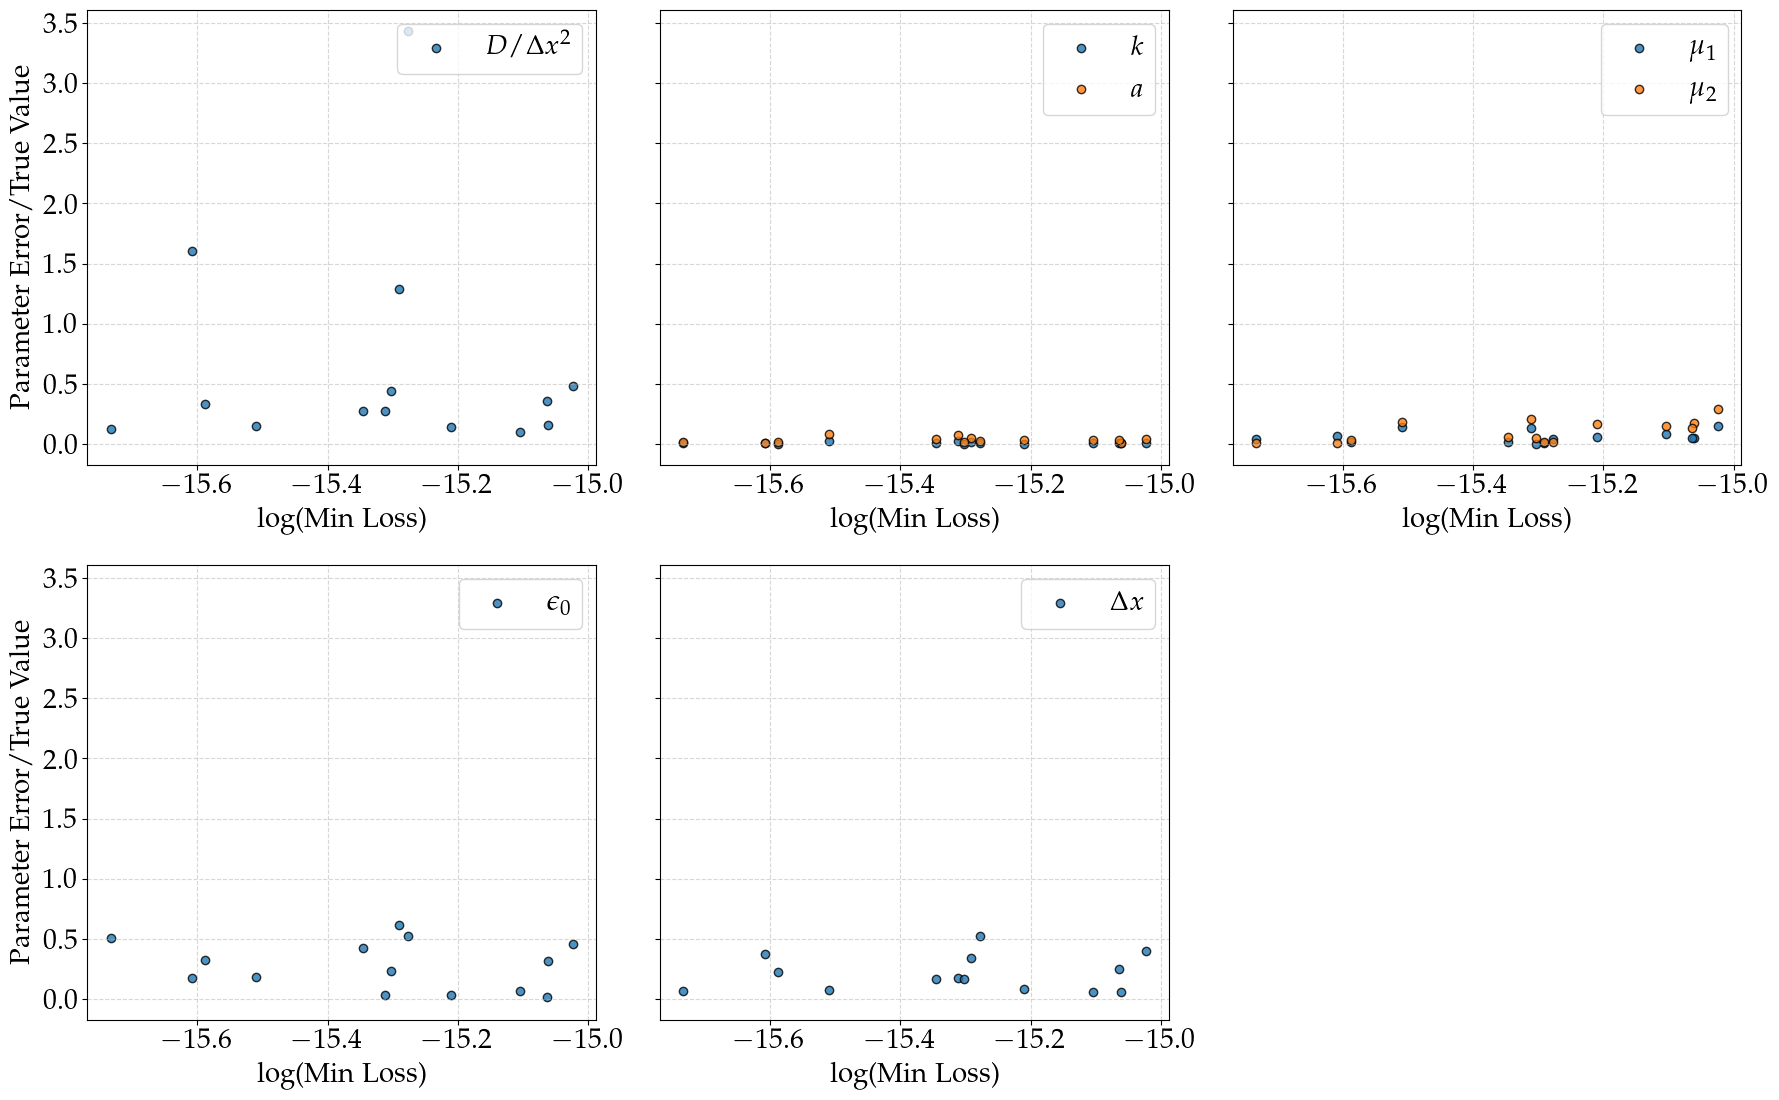

In [ ]:
plot_loss_vs_param_error_multi_subplots(
    losses,
    params,
    params_true_scroll,
    selected_key_groups=[
        ['D'],
        ['k','a'],
        ['mu_1','mu_2'],
        ['epsilon_0'],
        ['spacing']
    ],
    param_labels= param_labels,
    file_path_out= file_path_APAP_spiral_out,save_data=False
)
